# Forecasting - Facebook Prophet

https://facebook.github.io/prophet/

https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/

https://peerj.com/preprints/3190.pdf

In [15]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt





%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [16]:
#attention might have problems with holiday package, 
#downgrate holidays via: pip install 'holidays==0.9.12'
from fbprophet import Prophet

In [17]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Trivial Forecast (rolling mean)

In [19]:
# the final trivial model is at the end of this file

df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

In [20]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


# Small data set

In [21]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})

C:\Users\ADMIN\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning:

FixedFormatter should only be used together with FixedLocator



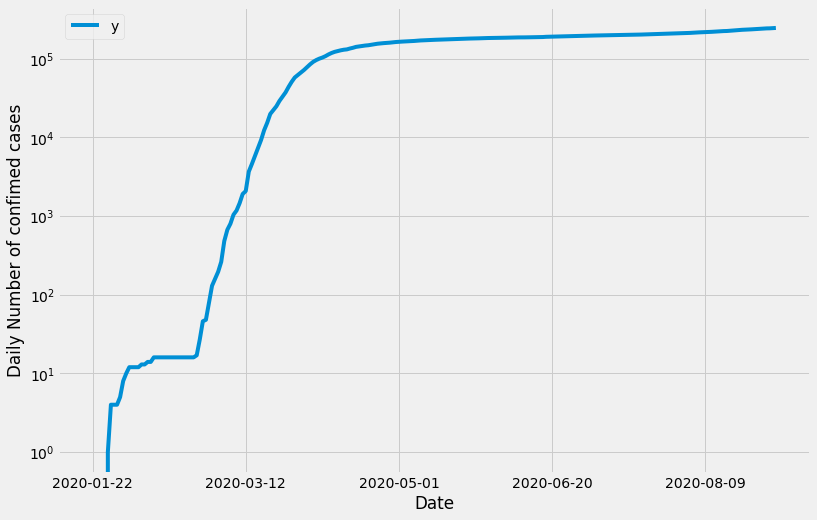

In [22]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()

In [23]:
# set the uncertainty interval to 95% (the Prophet default is 80%)

#my_model = Prophet(interval_width=0.95) # piecewise linear model
my_model = Prophet(growth='logistic')   # logistic model

In [24]:
# the column 'cap' is only mandatory for the logistic model
df['cap']=1000000.
my_model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
# define the periods and the frequency 'D'== days

future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
226,2020-09-04,1000000.0
227,2020-09-05,1000000.0
228,2020-09-06,1000000.0
229,2020-09-07,1000000.0
230,2020-09-08,1000000.0


In [26]:
# predict according to the scikit-learn standard

forecast = my_model.predict(future_dates)

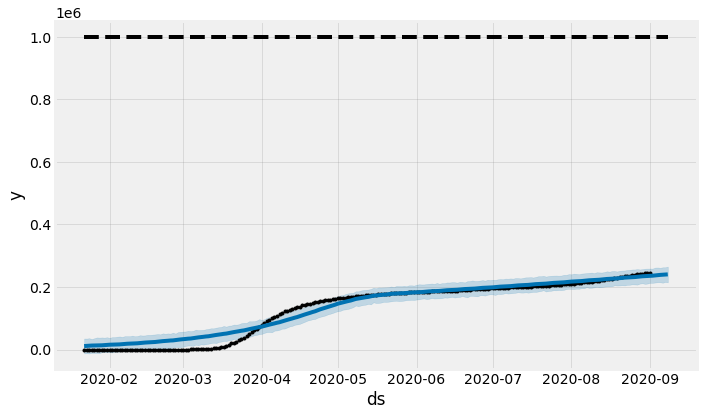

In [27]:
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [28]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [29]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,11654.151469,1000000.0,-12243.646222,35351.429170,11654.151469,11654.151469,-419.084916,-419.084916,-419.084916,-419.084916,-419.084916,-419.084916,0.0,0.0,0.0,11235.066554
1,2020-01-23,11972.670862,1000000.0,-11707.125221,35113.191610,11972.670862,11972.670862,-129.156783,-129.156783,-129.156783,-129.156783,-129.156783,-129.156783,0.0,0.0,0.0,11843.514079
2,2020-01-24,12299.787364,1000000.0,-12479.208615,36214.018675,12299.787364,12299.787364,222.818217,222.818217,222.818217,222.818217,222.818217,222.818217,0.0,0.0,0.0,12522.605581
3,2020-01-25,12635.727021,1000000.0,-10446.507747,33766.133887,12635.727021,12635.727021,222.104981,222.104981,222.104981,222.104981,222.104981,222.104981,0.0,0.0,0.0,12857.832002
4,2020-01-26,12980.721491,1000000.0,-10977.082441,36130.170688,12980.721491,12980.721491,54.070145,54.070145,54.070145,54.070145,54.070145,54.070145,0.0,0.0,0.0,13034.791636


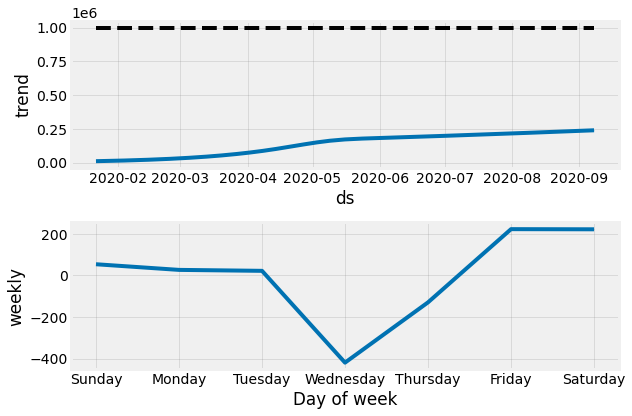

In [30]:
my_model.plot_components(forecast);

<AxesSubplot:xlabel='ds'>

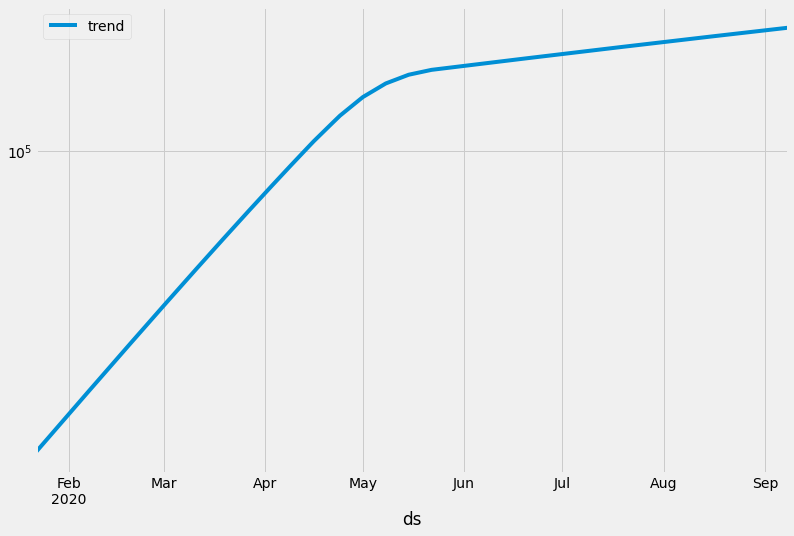

In [31]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

# Cross-Validation

In [38]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='40 days', # we take the first 30 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future

INFO:fbprophet:Making 177 forecasts with cutoffs between 2020-03-02 00:00:00 and 2020-08-25 00:00:00


In [39]:
df_cv.sort_values(by=['cutoff','ds'])[0:12]
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-03,-1.521279,-47.510299,40.567825,196,2020-03-02
1,2020-03-04,-2.223703,-42.208822,41.151182,262,2020-03-02
2,2020-03-05,1.173330,-44.689826,41.248828,482,2020-03-02
3,2020-03-06,2.063869,-38.592101,46.713435,670,2020-03-02
4,2020-03-07,7.947935,-31.121064,49.879076,799,2020-03-02


In [40]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [41]:
# the performance matrix shows the result for all horizon
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.475413e+09,38411.108369,29959.948850,0.199221,0.233648,0.254237
1,2 days,1.742005e+09,41737.331618,33125.252838,0.226415,0.276158,0.254237
2,3 days,2.060324e+09,45390.788026,36557.291836,0.255750,0.316926,0.254237
3,4 days,2.442004e+09,49416.634281,40284.759382,0.287136,0.362008,0.242938
4,5 days,2.902938e+09,53878.922442,44342.339731,0.319731,0.390774,0.242938
5,6 days,3.462069e+09,58839.345323,48764.871633,0.355827,0.413392,0.242938
6,7 days,4.145852e+09,64388.287600,53607.889218,0.394172,0.432796,0.242938


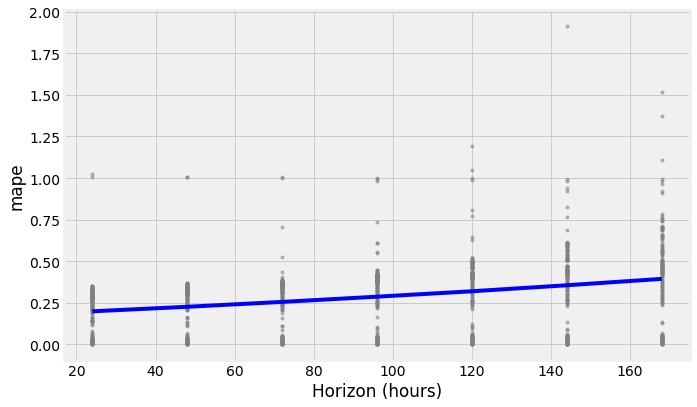

In [42]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

# Diagonalplot

# gives a good understanding for the under and over estimation w.r.t. magnitude

In [43]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [44]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
1210,2020-08-28,228610.029440,203908.174515,251872.165361,242126,2020-08-21,7 days
1217,2020-08-29,230142.837361,207873.918818,250656.341997,242835,2020-08-22,7 days
1224,2020-08-30,230912.900927,205969.471071,255119.642082,243305,2020-08-23,7 days
1231,2020-08-31,228598.311943,208953.427669,249316.186950,244802,2020-08-24,7 days
1238,2020-09-01,231804.039591,211387.598636,252524.268903,246015,2020-08-25,7 days


In [45]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

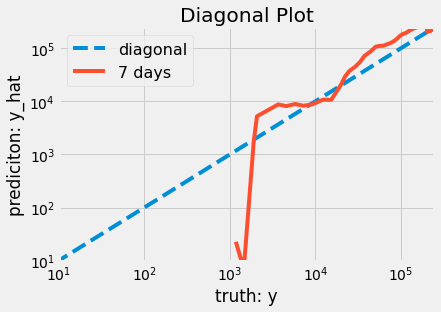

In [47]:
fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forecast

Example trivial forecast, prediciton 7 days into the future

In [48]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [49]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

# One of the standard forecast is a rolling mean

An other standard forecast is the exponentially-weighted moving average, see pandas.ewma

In [50]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean() # take the average of 3 days

In [51]:
# the result has to be shifted according to the prediciton horizon (here 7 days)

df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 134.67426019826163


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000,NaT,NaN,NaT
3,2020-01-25,0,0.000000,NaT,NaN,NaT
4,2020-01-26,0,0.000000,NaT,NaN,NaT
5,2020-01-27,1,0.333333,NaT,NaN,NaT
6,2020-01-28,4,1.666667,NaT,NaN,NaT
7,2020-01-29,4,3.000000,2020-01-22,NaN,7 days
8,2020-01-30,4,4.000000,2020-01-23,NaN,7 days
9,2020-01-31,5,4.333333,2020-01-24,0.000000,7 days
